In [1]:
import pandas as pd
import numpy as np
import scipy
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import xgboost as xgb

from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.linear_model import RidgeCV
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

%matplotlib inline

In [2]:
df_train = pd.read_csv("data/train.csv", low_memory=False, parse_dates=[2])
df_test = pd.read_csv("data/test.csv", low_memory=False, parse_dates=[3])
df_store = pd.read_csv("data/store.csv", low_memory=False)

### Sales prediction (Rossmann store sales)
### https://www.kaggle.com/c/rossmann-store-sales

The task is to predict sales in 1115 Rossmann stores for a 6-week horizon, according to available data.

##### Dataset structure:

Id - observation id in test set;  
Store - store identifier;  
Sales - sales per day;  
Customers - number of customers per day;  
Open - workday identifier for store : 0 = store closed, 1 = store open;  
StateHoliday - a = holiday, b = Easter, c = Christmas, 0 = work day;  
SchoolHoliday - are schools open that day;  
StoreType - 4 types of stores;  
Assortment - store assortment: a = basic, b = extra, c = extended;  
CompetitionDistance - distance to closest competitor;  
CompetitionOpenSince[Month/Year] - date when closest competitor opened;  
Promo - is there a promo action in the store that day;  
Promo2 - is store participating in renewable promo campaign: 0 = no, 1 = yes;  
Promo2Since[Year/Week] - date when Promo2 started;  
PromoInterval - Promo2 restart interval (in months annually);

The dataset consists of three continuous quantitative variables (Sales, Customers, CompetitionDistance, the first two missing in the test set), timestamps (Date, DayOfWeek, CompetitionOpenSince, Promo2Since, PromoInterval), from which it is possible to create quantitative variables. There are also 8 categorical variables.

The goal is to build a predictive regression model, based on the listed attributes, and, possibly, on the existing 1115 time series of sales for each store. The model should be capable of predicting sales for 6 weeks in advance.

### Exploratory data analysis and feature engineering.

Check for missing data.

In [3]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
Store            1017209 non-null int64
DayOfWeek        1017209 non-null int64
Date             1017209 non-null datetime64[ns]
Sales            1017209 non-null int64
Customers        1017209 non-null int64
Open             1017209 non-null int64
Promo            1017209 non-null int64
StateHoliday     1017209 non-null object
SchoolHoliday    1017209 non-null int64
dtypes: datetime64[ns](1), int64(7), object(1)
memory usage: 69.8+ MB


In [4]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41088 entries, 0 to 41087
Data columns (total 8 columns):
Id               41088 non-null int64
Store            41088 non-null int64
DayOfWeek        41088 non-null int64
Date             41088 non-null datetime64[ns]
Open             41077 non-null float64
Promo            41088 non-null int64
StateHoliday     41088 non-null object
SchoolHoliday    41088 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(5), object(1)
memory usage: 2.5+ MB


In [5]:
df_test[df_test["Open"].isna()]

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
479,480,622,4,2015-09-17,NaN,1,0,0
1335,1336,622,3,2015-09-16,NaN,1,0,0
2191,2192,622,2,2015-09-15,NaN,1,0,0
3047,3048,622,1,2015-09-14,NaN,1,0,0
4759,4760,622,6,2015-09-12,NaN,0,0,0
5615,5616,622,5,2015-09-11,NaN,0,0,0
6471,6472,622,4,2015-09-10,NaN,0,0,0
7327,7328,622,3,2015-09-09,NaN,0,0,0
8183,8184,622,2,2015-09-08,NaN,0,0,0
9039,9040,622,1,2015-09-07,NaN,0,0,0


In [6]:
df_train[df_train["Store"]==622]["Open"].value_counts()

1    784
0    158
Name: Open, dtype: int64

In the training set, all values are known. In the test set, several values of the "Open" attribute are missing. All relate to store number 622. The ratio of the values of this attribute in the known data is 784/158, besides, missed days refer to weekdays, and some indicate the presence of a promotion. For these reasons, and also because of the required quality metric (below), the missing values are filled by 1.

In [7]:
df_test["Open"] = df_test["Open"].fillna(1)

In [8]:
df_store.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
Store                        1115 non-null int64
StoreType                    1115 non-null object
Assortment                   1115 non-null object
CompetitionDistance          1112 non-null float64
CompetitionOpenSinceMonth    761 non-null float64
CompetitionOpenSinceYear     761 non-null float64
Promo2                       1115 non-null int64
Promo2SinceWeek              571 non-null float64
Promo2SinceYear              571 non-null float64
PromoInterval                571 non-null object
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


There are several series with missing values in the store dataset. Missing data in the Promo2 section corresponds to the non-participation of the store in these promotions. Also partially unfilled is the Competition section. All this data was encoded by -1 (checks on the first models showed the advantage of this over filling in the median value).
Before this, the dates of the start of competition and the store’s participation in a renewable promo campaign were collected from separate columns and converted to int. And also, the values of "PromoInterval" are split into four numerical variables according to the month numbers.

In [9]:
def competition_date(data):
    if np.isnan(data["CompetitionOpenSinceYear"]):
        return np.nan
    y = int(data["CompetitionOpenSinceYear"])
    m = int(data["CompetitionOpenSinceMonth"])
    return pd.datetime.strptime("{}-{}".format(y, m), "%Y-%m")

df_store["CompetitionSince"] = df_store.apply(competition_date, axis=1)
df_store["CompetitionSinceInt"] = df_store["CompetitionSince"].astype(np.int64)

def promo2_date(data):
    if np.isnan(data["Promo2SinceYear"]):
        return np.nan
    y = int(data["Promo2SinceYear"])
    w = int(data["Promo2SinceWeek"])
    return pd.datetime.strptime("{} {} 1".format(y, w), "%Y %W %w")

df_store["Promo2Since"] = df_store.apply(promo2_date, axis=1)
df_store["Promo2SinceInt"] = df_store["Promo2Since"].astype(np.int64)

In [10]:
month_dict = {"Jan": 1, "Feb": 2, "Mar": 3, "Apr": 4, "May": 5, "Jun": 6,
             "Jul": 7, "Aug": 8, "Sept": 9, "Oct": 10, "Nov": 11, "Dec": 12}

def make_intervals(data):
    if pd.isnull(data["PromoInterval"]):
        data["PromoInterval1"] = np.nan
        data["PromoInterval2"] = np.nan
        data["PromoInterval3"] = np.nan
        data["PromoInterval4"] = np.nan
    else:
        pi = data["PromoInterval"].split(",")
        data["PromoInterval1"] = month_dict[pi[0]]
        data["PromoInterval2"] = month_dict[pi[1]]
        data["PromoInterval3"] = month_dict[pi[2]]
        data["PromoInterval4"] = month_dict[pi[3]]
    return data

df_store = df_store.apply(make_intervals, axis=1)

df_store.fillna(-1, inplace=True)

The training set contains sales values equal to 0, in some cases, when the store is open. It may be data errors, besides, zero sales are ignored in the quality metric. These observations have been deleted.

In [11]:
print("Number of zero sales when store is open: {}".format(df_train[(df_train["Sales"]==0) & (df_train["Open"]==1)].shape[0]))
mask = (df_train["Sales"]==0) & (df_train["Open"]==1)
df_train = df_train[~mask]

Number of zero sales when store is open: 54


Distributions of numerical variables are asymmetric and have long right tails, which looks like lognormal distribution. To verify this, they were logarithmized, which reduced asymmetry. The logarithms of sales values will be used as the target variable for the models.

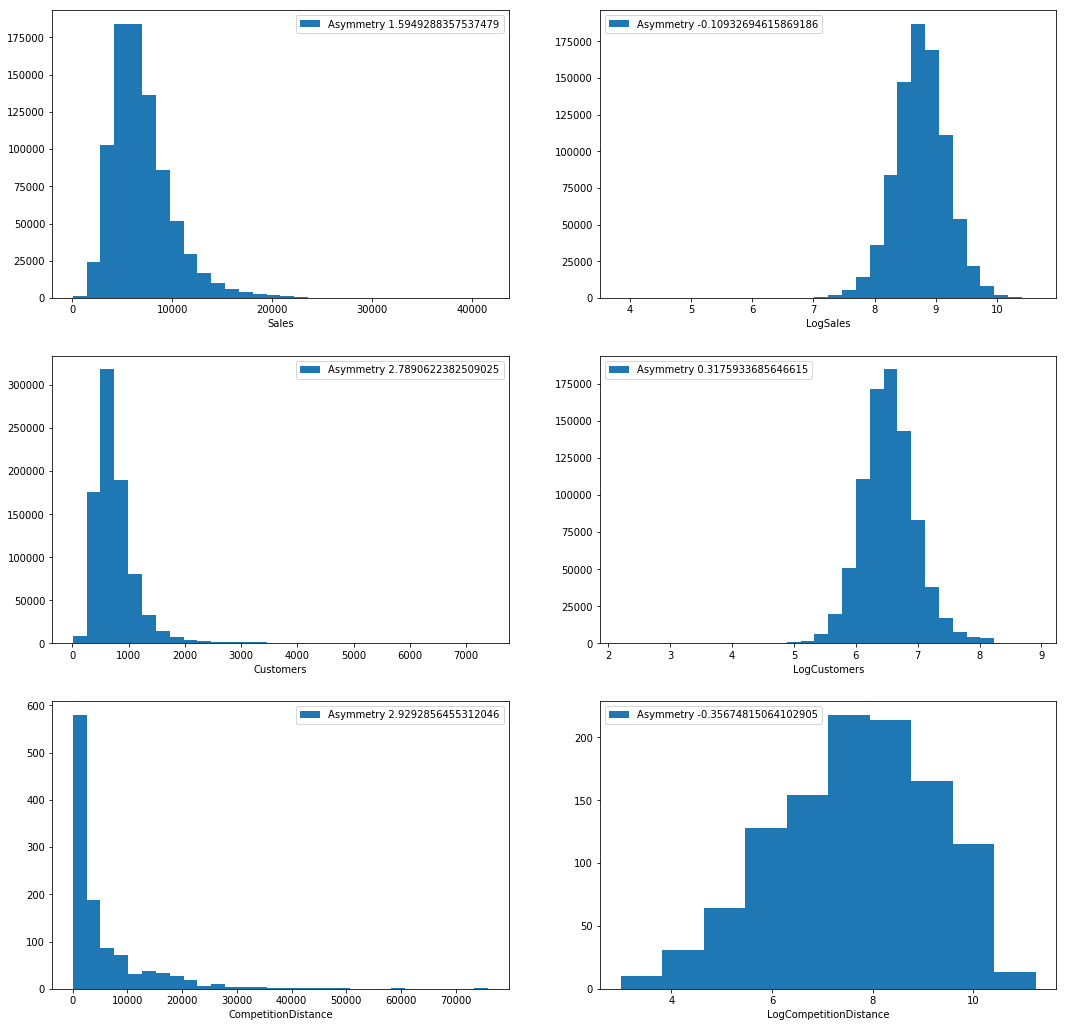

In [12]:
mask_sales = df_train["Sales"]>0
plt.figure(figsize=(18,18))
plt.subplot(3, 2, 1)
plt.hist(df_train.loc[mask_sales, "Sales"], bins=30, label="Asymmetry {}".format(df_train.loc[mask_sales, "Sales"].skew()))
plt.xlabel("Sales")
plt.legend()
plt.subplot(3, 2, 2)
plt.hist(np.log1p(df_train.loc[mask_sales, "Sales"]), bins=30, label="Asymmetry {}".format(np.log1p(df_train.loc[mask_sales, "Sales"]).skew()))
plt.xlabel("LogSales")
plt.legend()
plt.subplot(3, 2, 3)
plt.hist(df_train.loc[mask_sales, "Customers"], bins=30, label="Asymmetry {}".format(df_train.loc[mask_sales, "Customers"].skew()))
plt.xlabel("Customers")
plt.legend()
plt.subplot(3, 2, 4)
plt.hist(np.log1p(df_train.loc[mask_sales, "Customers"]), bins=30, label="Asymmetry {}".format(np.log1p(df_train.loc[mask_sales, "Customers"]).skew()))
plt.xlabel("LogCustomers")
plt.legend()
mask_com = df_store["CompetitionDistance"]>0
plt.subplot(3, 2, 5)
plt.hist(df_store.loc[mask_com, "CompetitionDistance"], bins=30, label="Asymmetry {}".format(df_store.loc[mask_com, "CompetitionDistance"].skew()))
plt.xlabel("CompetitionDistance")
plt.legend()
plt.subplot(3, 2, 6)
plt.hist(np.log(df_store.loc[mask_com, "CompetitionDistance"]), bins=10, label="Asymmetry {}".format(np.log(df_store.loc[mask_com,"CompetitionDistance"]).skew()))
plt.xlabel("LogCompetitionDistance")
plt.legend()
plt.show()

In [13]:
df_train["LogSales"] = np.log1p(df_train["Sales"])
df_train["LogCustomers"] = np.log1p(df_train["Customers"])
df_store.loc[mask_com, "LogCompetitionDistance"] = np.log1p(df_store.loc[mask_com, "CompetitionDistance"])
df_store["LogCompetitionDistance"] = df_store["LogCompetitionDistance"].fillna(-1)

Initial feature list. All 4 columns of the monthly Promo2 intervals are correlated, one will be enough. And Promo2 variable itself is already redundant.

In [14]:
features_log = ["Store", "Promo", "StateHoliday", "SchoolHoliday", "StoreType", 
                   "Assortment", "LogCompetitionDistance", "CompetitionSinceInt", "PromoInterval1", "Promo2SinceInt"]

Categorical feature "StateHoliday" has to be encoded.

In [15]:
stahol = {"0": 0, "a": 1, "b": 2, "c": 3}
df_train["StateHoliday"].replace(stahol, inplace=True)
df_test["StateHoliday"].replace(stahol, inplace=True)

Linear relationships between variables. Very strong correlation, not surprisingly, of sales with the number of customers. However, the customers data is absent in the test set. Because of that, there is a need to create on its basis new features that can be used in the "future". There is also some correlation of sales with Promo and holidays.

In [16]:
df_train[["LogSales", "LogCustomers", "Promo", "SchoolHoliday", "StateHoliday"]].corr()

,LogSales,LogCustomers,Promo,SchoolHoliday,StateHoliday
LogSales,1.000000,0.996252,0.337165,0.090437,-0.338401
LogCustomers,0.996252,1.000000,0.328036,0.090439,-0.335721
Promo,0.337165,0.328036,1.000000,0.067490,-0.024157
SchoolHoliday,0.090437,0.090439,0.067490,1.000000,0.196432
StateHoliday,-0.338401,-0.335721,-0.024157,0.196432,1.000000


Creating additional features for stores. For this, aggregated values of average sales by store, average number of customers, and average check (sales / customers) are used. Similarly, sales by day of the week are aggregated and, in more detail, average sales for each store by day of the week.

In [17]:
# Store mean
stores = df_train.groupby("Store")

def map_sales_means(data):
    data["Sales_mean"] = data["Store"].map(stores["Sales"].mean())
    data["Customers_mean"] = data["Store"].map(stores["Customers"].mean())
    data["SPC_mean"] = data["Store"].map(stores["Sales"].mean()/stores["Customers"].mean())    
    data["LogSales_mean"] = data["Store"].map(stores["LogSales"].mean())
    data["LogCustomers_mean"] = data["Store"].map(stores["LogCustomers"].mean())
    data["LogSPC_mean"] = data["Store"].map(stores["LogSales"].mean()/stores["LogCustomers"].mean())    

map_sales_means(df_train)
map_sales_means(df_test)

# Day mean
weekdays = df_train[df_train["Sales"]>0].groupby(["DayOfWeek"])

df_train["Weekdays_mean"] = df_train["DayOfWeek"].map(weekdays["Sales"].mean())
df_test["Weekdays_mean"] = df_test["DayOfWeek"].map(weekdays["Sales"].mean())
df_train["LogWeekdays_mean"] = df_train["DayOfWeek"].map(weekdays["LogSales"].mean())
df_test["LogWeekdays_mean"] = df_test["DayOfWeek"].map(weekdays["LogSales"].mean())

# Mean by day by store
wd_stores = df_train[df_train["Sales"]>0].groupby(["Store", "DayOfWeek"])
wd_stores_s = wd_stores["Sales"].mean()
wd_stores_log = wd_stores["LogSales"].mean()

def map_wd_mean(data):
    for s in data["Store"].unique():
        for wd in data["DayOfWeek"].unique():
            if wd in wd_stores_s[s]:
                data.loc[(data["Store"]==s) & (data["DayOfWeek"]==wd), "Store_WD_mean"] = wd_stores_s[s, wd]        
                data.loc[(data["Store"]==s) & (data["DayOfWeek"]==wd), "LogStore_WD_mean"] = wd_stores_log[s, wd]
                
map_wd_mean(df_train)
map_wd_mean(df_test)

df_train["Store_WD_mean"] = df_train["Store_WD_mean"].fillna(0)
df_train["LogStore_WD_mean"] = df_train["LogStore_WD_mean"].fillna(0)
df_test["Store_WD_mean"] = df_test["Store_WD_mean"].fillna(0)
df_test["LogStore_WD_mean"] = df_test["LogStore_WD_mean"].fillna(0)

features_log += ["LogSales_mean", "LogCustomers_mean", "LogSPC_mean", "LogWeekdays_mean", "LogStore_WD_mean"]

Correlations of new features with sales. The greatest linear relationship is seen with the last created feature.

In [18]:
df_train[["LogSales"] + ["LogSales_mean", "LogCustomers_mean", "LogSPC_mean", "LogWeekdays_mean", "LogStore_WD_mean"]].corr()

,LogSales,LogSales_mean,LogCustomers_mean,LogSPC_mean,LogWeekdays_mean,LogStore_WD_mean
LogSales,1.000000,0.112888,0.102960,-0.047684,0.113292,0.883534
LogSales_mean,0.112888,1.000000,0.912055,-0.422399,0.000014,0.115161
LogCustomers_mean,0.102960,0.912055,1.000000,-0.753343,0.000019,0.105042
LogSPC_mean,-0.047684,-0.422399,-0.753343,1.000000,-0.000019,-0.049068
LogWeekdays_mean,0.113292,0.000014,0.000019,-0.000019,1.000000,0.161529
LogStore_WD_mean,0.883534,0.115161,0.105042,-0.049068,0.161529,1.000000


The distribution of sales by store type shows that only type "b" has a strong influence. Average in assortment differ by 10-20%. These categorical features are encoded in ascending order.

In [19]:
stotyp = {"a": 1, "b": 3, "c": 2, "d": 0}
assort = {"a": 0, "b": 2, "c": 1}
df_store["StoreType"].replace(stotyp, inplace=True)
df_store["Assortment"].replace(assort, inplace=True)

# Merging sales and stores data.
df_train = pd.merge(df_train, df_store, how='left', on=['Store'])
df_test = pd.merge(df_test, df_store, how='left', on=['Store'])

In [20]:
df_train[df_train["Sales"]>0].groupby("StoreType")["Sales"].mean()

StoreType
0     6822.300064
1     6925.697986
2     6933.126425
3    10233.380141
Name: Sales, dtype: float64

In [21]:
df_train[df_train["Sales"]>0].groupby("Assortment")["Sales"].mean()

Assortment
0    6621.523057
1    7300.843547
2    8642.503594
Name: Sales, dtype: float64

Creation of numerical variables from dates, such as week, month, year, etc. Other features were also tested, such as, whether the current month is the beginning of "Promo2", the number of days before / after the holidays, or "Promo". They were excluded because they increased the model error.

In [22]:
df_train["DateOrd"] = df_train["Date"].apply(lambda x: x.toordinal() if not pd.isnull(x) else np.nan)
df_test["DateOrd"] = df_test["Date"].apply(lambda x: x.toordinal() if not pd.isnull(x) else np.nan)

df_train["DayNumber"] = df_train["DateOrd"]-734869
df_test["DayNumber"] = df_test["DateOrd"]-734869

df_train["DayOfMonth"] = pd.Index(df_train["Date"]).day
df_train["DayOfYear"] = pd.Index(df_train["Date"]).dayofyear
df_train["WeekOfYear"] = pd.Index(df_train["Date"]).week
df_train["MonthNumber"] = pd.Index(df_train["Date"]).month
df_train["QuarterNumber"] = pd.Index(df_train["Date"]).quarter
df_train["YearNumber"] = pd.Index(df_train["Date"]).year

df_test["DayOfMonth"] = pd.Index(df_test["Date"]).day
df_test["DayOfYear"] = pd.Index(df_test["Date"]).dayofyear
df_test["WeekOfYear"] = pd.Index(df_test["Date"]).week
df_test["MonthNumber"] = pd.Index(df_test["Date"]).month
df_test["QuarterNumber"] = pd.Index(df_test["Date"]).quarter
df_test["YearNumber"] = pd.Index(df_test["Date"]).year

features_log += ["DayOfWeek", "DayOfMonth", "DayOfYear", "WeekOfYear", "YearNumber", "MonthNumber"]

### Store sales time series analysis.

Charts of sales time series show seasonality, and in some stores trends are observed. Those components were extracted from the time series. Trends were approximated by quadratic and cubic polynomials using ridge regression. Subsequently, the extrapolated outputs of these models were used as new features. Periodic oscillations were extracted through the Fourier transformation of series with a removed trend. These values were not used for forecasting, due to high risk of overfitting. They were used to deal with outliers.

In [24]:
# Creates pivot table of sales by store per date.
df_timeseries = df_train[["DateOrd", "Store", "LogSales"]]
df_timeseries = pd.pivot_table(df_timeseries, values="LogSales", index="DateOrd", columns="Store").copy()
df_timeseries.fillna(df_timeseries[df_timeseries>0].mean(), inplace=True)
date_ord0 = df_timeseries.index[0]
df_timeseries.index = df_timeseries.index - date_ord0

# Trends calculations.
reg_poly = RidgeCV()
def get_logtrends(store): 
    mask = df_timeseries[store].values > 0
    X_poly = df_timeseries[mask].index.values.reshape(-1, 1).astype(np.float64)
    scaler_time = MinMaxScaler()
    X_poly = scaler_time.fit_transform(X_poly)
    X_poly2 = np.c_[X_poly, X_poly**2]
    X_poly3 = np.c_[X_poly, X_poly**2, X_poly**3]    
    y_poly = df_timeseries.loc[mask, store].values    
        
    X_full = np.concatenate((sorted(df_train["DateOrd"].unique()), sorted(df_test["DateOrd"].unique()))) - date_ord0
    X_full = X_full.reshape(-1, 1).astype(np.float64)
    X_full = scaler_time.transform(X_full)
    X_full2 = np.c_[X_full, X_full**2]
    X_full3 = np.c_[X_full, X_full**2, X_full**3]
    
    reg_poly.fit(X_poly2, y_poly)
    trend2 = reg_poly.predict(X_full2)
    reg_poly.fit(X_poly3, y_poly)
    trend3 = reg_poly.predict(X_full3)
    return trend2, trend3

df_timeseries_test = pd.DataFrame(index=sorted(df_test["DateOrd"].unique()) - date_ord0)

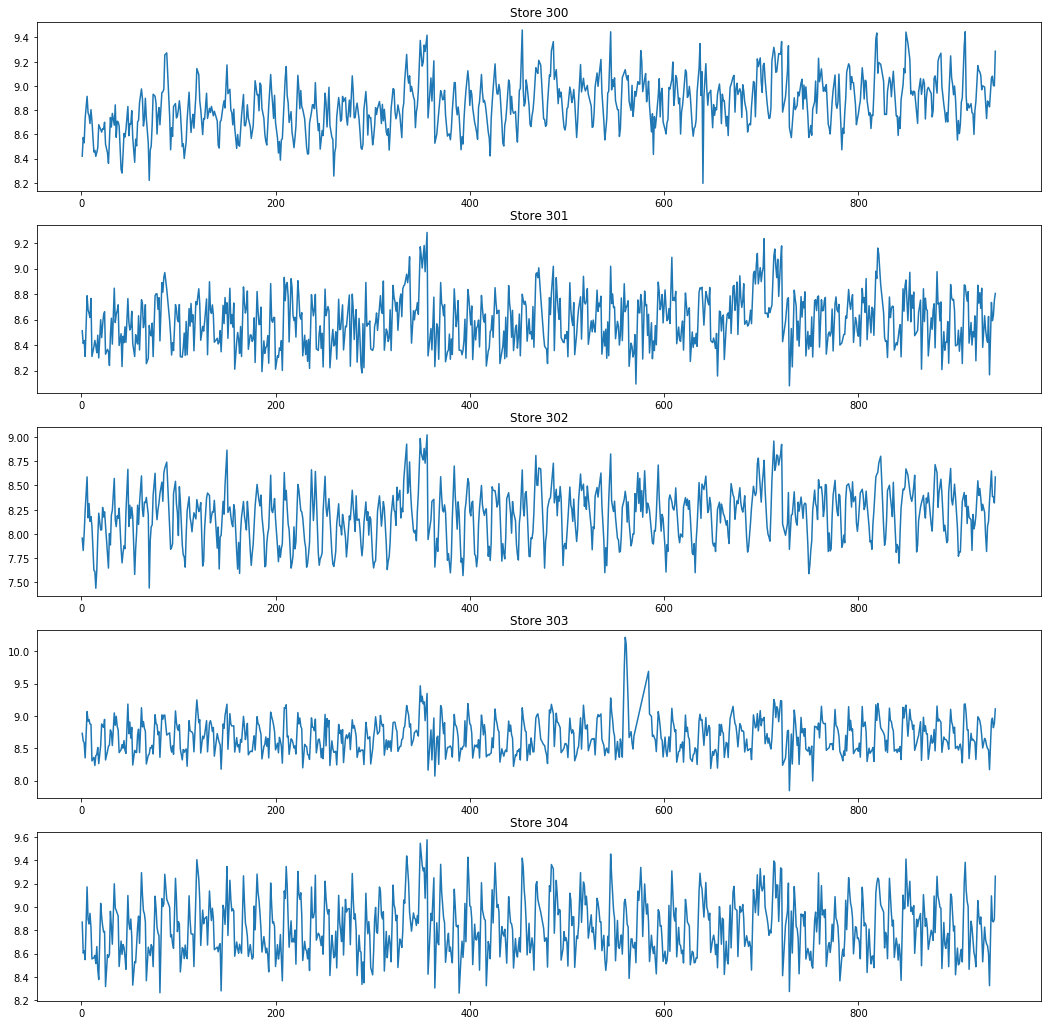

In [25]:
fig, ax = plt.subplots(5, 1, figsize=(18, 18))

st = 300
for i in range(st, st+5):
    mask = df_timeseries[i].values > 0
    plot_vals = df_timeseries.loc[mask, i]
    ax[i-st].plot(plot_vals)    
    ax[i-st].set_title("Store {}".format(i))    
    
plt.show()

Charts of extracted trends. For some stores there are missing sales observations for some time interval. They were filled with mean values.

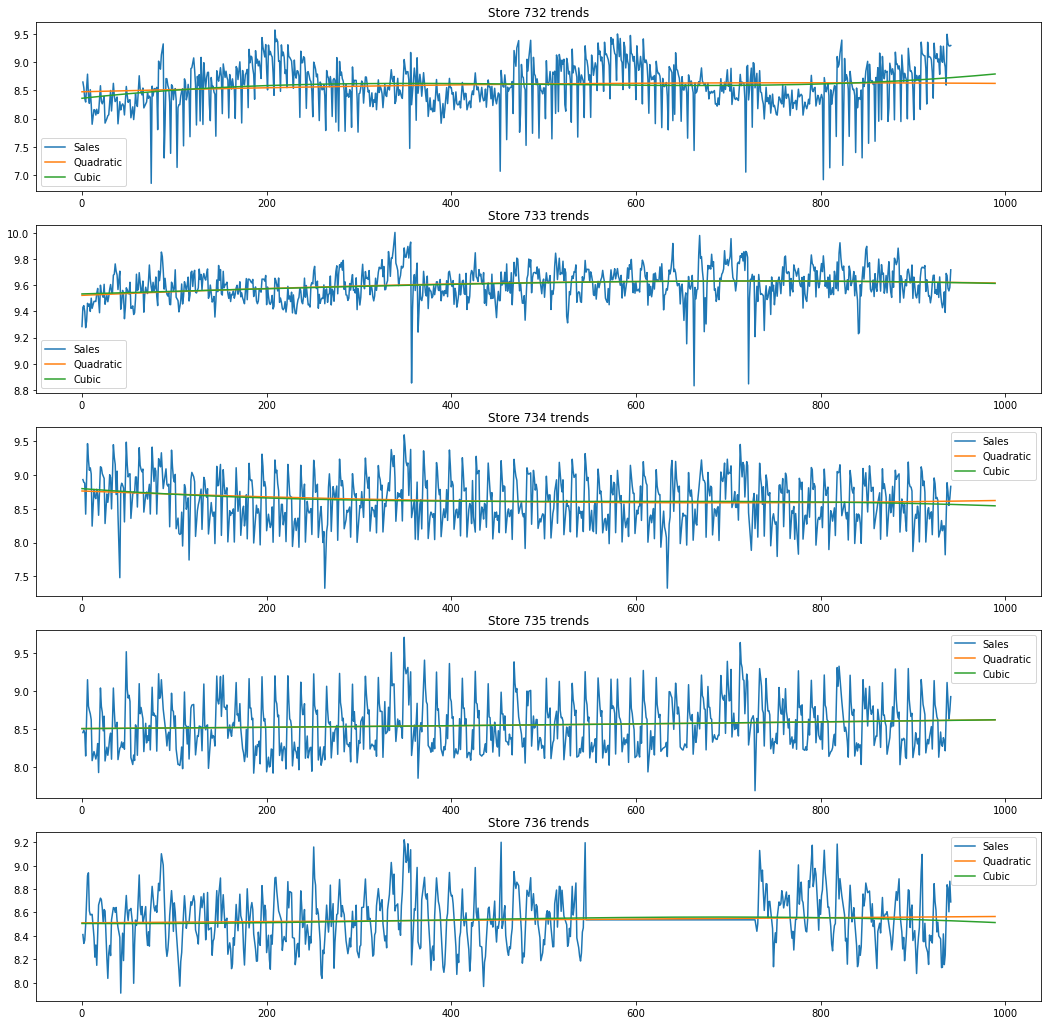

In [33]:
fig, ax = plt.subplots(5, 1, figsize=(18, 18))

st = 732
for i in range(st, st+5):
    mask = df_timeseries[i].values > 0
    plot_vals = df_timeseries.loc[mask, i]
    ax[i-st].plot(plot_vals, label="Sales")
    ax[i-st].plot(get_logtrends(i)[0], label="Quadratic")
    ax[i-st].plot(get_logtrends(i)[1], label="Cubic")  
    ax[i-st].set_title("Store {} trends".format(i))    
    ax[i-st].legend()
    
plt.show()

In [34]:
# Puts trends and detrended data in table.
for i in range(1, 1116):
    trend2, trend3 = get_logtrends(i)
    df_timeseries["LogTrend2_{}".format(i)] = trend2[:942]    
    df_timeseries_test["LogTrend2_{}".format(i)] = trend2[942:]
    df_timeseries["LogTrend3_{}".format(i)] = trend3[:942]    
    df_timeseries_test["LogTrend3_{}".format(i)] = trend3[942:]
    df_timeseries["Detrended2_{}".format(i)] = (df_timeseries[i] - df_timeseries["LogTrend2_{}".format(i)])    
    df_timeseries["Detrended3_{}".format(i)] = (df_timeseries[i] - df_timeseries["LogTrend3_{}".format(i)]) 

In [35]:
# Errors of trend approximations.
rmses2 = []
rmses3 = []

for i in range(1, 1116):     
    mask = df_timeseries[i].values > 0
    true = df_timeseries[mask][i].values
    trend2 = df_timeseries[mask]["LogTrend2_{}".format(i)].values
    trend3 = df_timeseries[mask]["LogTrend3_{}".format(i)].values    
    rmses2.append(np.sqrt(mean_squared_error(y_true=true, y_pred=trend2)))
    rmses3.append(np.sqrt(mean_squared_error(y_true=true, y_pred=trend3)))
    
print("RMSE of quadratic trend approximation: {0: .4f}".format(np.mean(rmses2)))
print("RMSE of cubic trend approximation: {0: .4f}".format(np.mean(rmses3)))

RMSE of quadratic trend approximation:  0.2579
RMSE of cubic trend approximation:  0.2576


Mean errors for different degrees of polynomials differ only in the fourth decimal place.

Stationarity testing of series with a removed trend using the Dickey-Fuller test. When using the cubic trend, there are three stores with non-stationary series. Below are charts of these series, in which long-term periodic fluctuations are visible, and in the last two some anomalies are observed, possibly lower outliers.

In [36]:
results2 = {}
results3 = {}

for i in range(1, 1116):  
    mask = df_timeseries[i].values > 0
    af_y = df_timeseries.loc[mask, "Detrended2_{}".format(i)].values        
    test = sm.tsa.adfuller(af_y)
    if test[1] > 0.05:
        results2[i] = test[1]    
    af_y = df_timeseries.loc[mask, "Detrended3_{}".format(i)].values        
    test = sm.tsa.adfuller(af_y)
    if test[1] > 0.05:
        results3[i] = test[1] 
print("Store numbers with non-stationary detrended time series (quadratic): {}".format([i for i in results2.keys()]))
print("Store numbers with non-stationary detrended time series (cubic): {}".format([i for i in results3.keys()]))

Store numbers with non-stationary detrended time series (quadratic): [530, 578, 732, 931]
Store numbers with non-stationary detrended time series (cubic): [530, 732, 931]


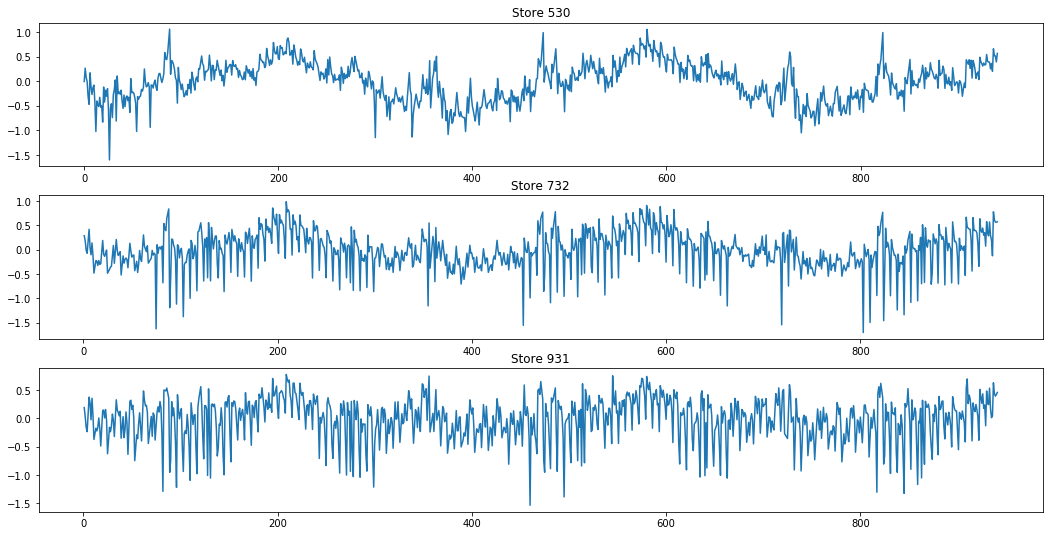

In [37]:
fig, ax = plt.subplots(3, 1, figsize=(18, 9))
i = 0
for s in results3.keys():
    ax[i].plot(df_timeseries.loc[df_timeseries[s] > 0, "Detrended3_{}".format(s)])
    ax[i].set_title("Store {}".format(s))    
    i += 1

Extraction of periodic components from series with removed trends. For this, the fast Fourier transform was used, then the wave functions were constructed based on the most pronounced frequencies. Next, those values were used to replace outliers.

In [38]:
def get_seasonal(store, freq_fraction=0.66): 
    mask = df_timeseries[store].values > 0
    w_detrended = df_timeseries.loc[mask, "Detrended3_{}".format(store)].values 
    length = w_detrended.shape[0]
    t = np.arange(length)
    
    s = np.fft.fft(w_detrended)
    freq = np.fft.fftfreq(length)
    inds_freq = np.arange(length)
    inds_freq = sorted(inds_freq, key = lambda i: np.absolute(freq[i]))    
    
    t = np.arange(length)
    seasonal = np.zeros(length)
    for i in inds_freq[:1 + int(length*freq_fraction)]:
        amplitude = np.absolute(s[i]) / length
        phase = np.angle(s[i])
        seasonal += amplitude * np.cos(2 * np.pi * freq[i] * t + phase)    

    return seasonal    

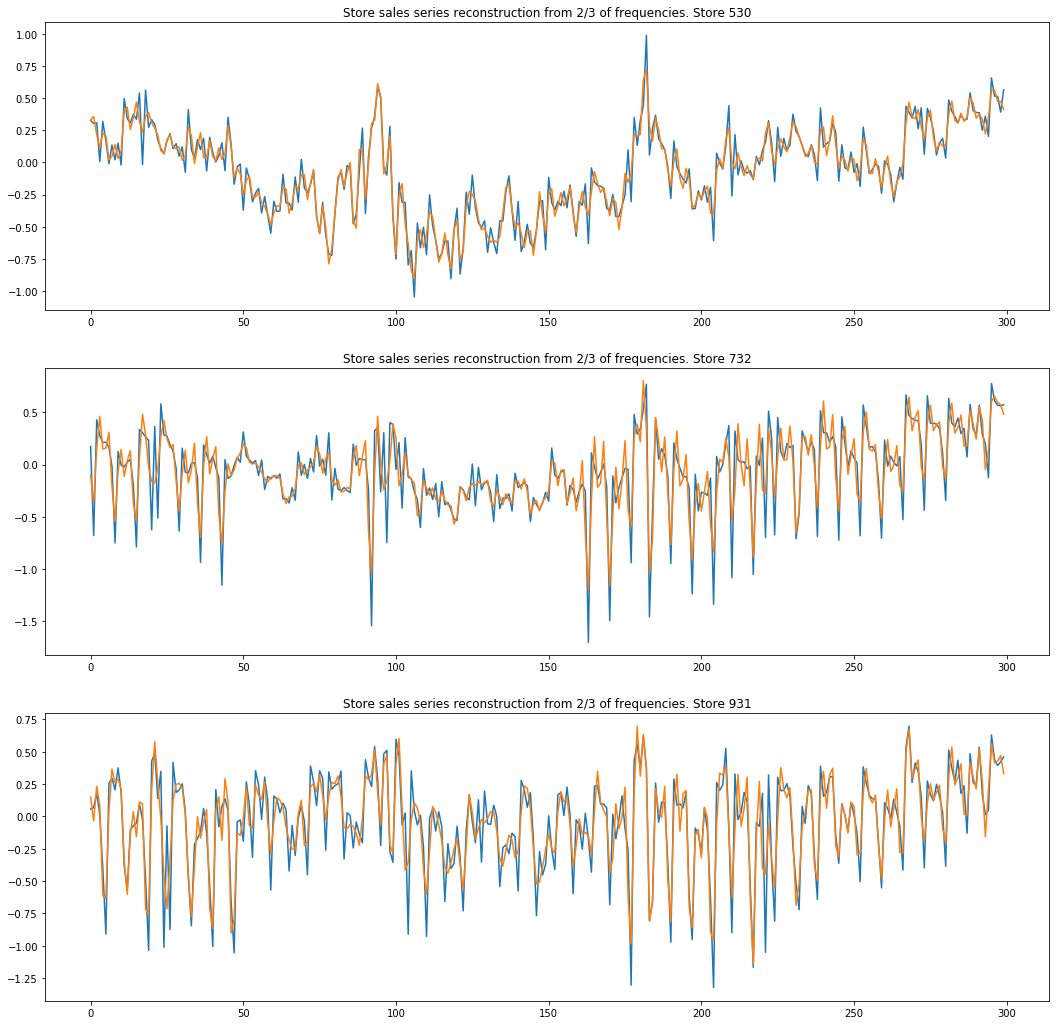

In [39]:
fig, ax = plt.subplots(3, 1, figsize=(18, 18))
i = 0
for s in results3.keys():
    ax[i].plot(df_timeseries.loc[df_timeseries[s]>0, "Detrended3_{}".format(s)].values[-300:])
    ax[i].plot(get_seasonal(s)[-300:])
    ax[i].set_title("Store sales series reconstruction from 2/3 of frequencies. Store {}".format(s))    
    i += 1

In [41]:
# Puts seasonal features in table.
for i in range(1, 1116):    
    seasonal = get_seasonal(i)
    mask = df_timeseries[i].values > 0
    df_timeseries.loc[mask, "Seasonal_{}".format(i)] = seasonal 
    df_timeseries.loc[mask, "Trend_Season_{}".format(i)] = df_timeseries.loc[mask, "LogTrend3_{}".format(i)] + \
                                                    df_timeseries.loc[mask, "Seasonal_{}".format(i)]

Moving the created features to the original tables.

In [42]:
def move_trends(source, target):
    for i in target["Store"].unique():
        inds_notnan = target.loc[target["Store"]==i]["DateOrd"].values
        target.loc[((target["Store"]==i) & (target["DateOrd"].isin(inds_notnan))), "LogTrend2"] = \
            source.loc[inds_notnan-date_ord0, "LogTrend2_{}".format(i)].values
        target.loc[((target["Store"]==i) & (target["DateOrd"].isin(inds_notnan))), "LogTrend3"] = \
            source.loc[inds_notnan-date_ord0, "LogTrend3_{}".format(i)].values        
        
move_trends(df_timeseries, df_train)
move_trends(df_timeseries_test, df_test)

for i in df_train["Store"].unique():
    inds_notnan = df_train.loc[df_train["Store"]==i]["DateOrd"].values
    df_train.loc[((df_train["Store"]==i) & (df_train["DateOrd"].isin(inds_notnan))), "Trend_Season"] = \
        df_timeseries.loc[inds_notnan-date_ord0, "Trend_Season_{}".format(i)].values
    
features_log += ["LogTrend2"]

Outlier detection. For this, the interquartile range was used. As an outlier was marked a value, that was more than 1.5 IQR or less than 1.75 IQR (due to more distant upward outbursts, sometimes, at 1.5 IQR, the entire lower boundary of the oscillation range was marked). The charts plot several stores sales with assigned outliers.

In [43]:
def get_outliers(data):    
    q75 = data.quantile(0.75)
    q25 = data.quantile(0.25)
    iqr =  q75 - q25
    out_high = q75 + 1.5*iqr
    out_low = q25 - 1.75*iqr
    return ((data > out_high) | (data < out_low))

for i in df_train["Store"].unique():
    df_train.loc[(df_train["Store"]==i) & (df_train["Sales"]>0), "Outlier"] = \
        get_outliers(df_train.loc[(df_train["Store"]==i) & (df_train["Sales"]>0), "LogSales"])

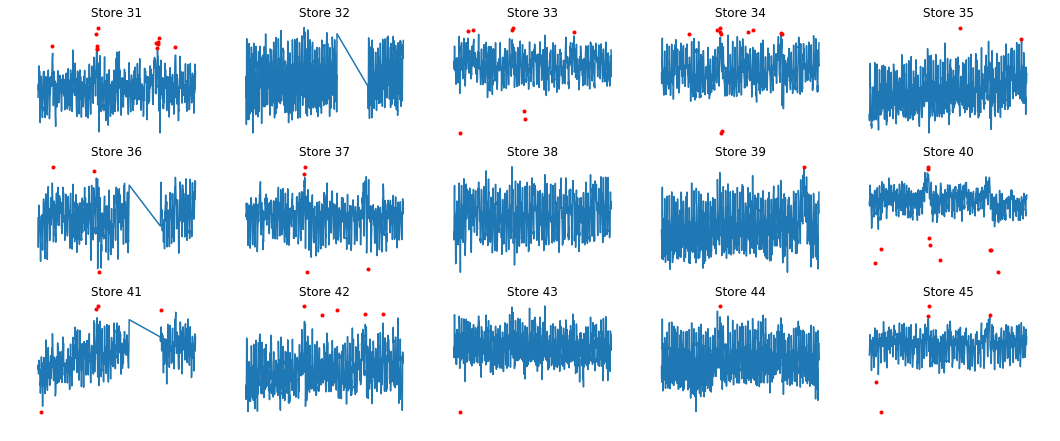

In [45]:
num = 15
st = 31
plt.figure(figsize=(18,38))
for i in range(st,num+st):
    store = i
    
    X1 = df_train.loc[(df_train["Store"] == store) & (df_train["Open"] == 1) & (df_train["Outlier"] == False)]["Date"]
    y1 = df_train.loc[(df_train["Store"] == store) & (df_train["Open"] == 1) & (df_train["Outlier"] == False)]["LogSales"]    
    X2 = df_train.loc[(df_train["Store"] == store) & (df_train["Open"] == 1) & (df_train["Outlier"] == True)]["Date"]
    y2 = df_train.loc[(df_train["Store"] == store) & (df_train["Open"] == 1) & (df_train["Outlier"] == True)]["LogSales"]    
    
    plt.subplot(15,5,i-st+1)
    plt.plot(X1, y1, "-")
    plt.plot(X2, y2, "r.")
    plt.title("Store {}".format(i))
    plt.axis("off")

Replacing outliers with values obtained by combining a cubic trend and periodic functions. The charts show the shift of marked values to the main range of fluctuations.

In [46]:
df_train.loc[:, "LogSales_Outliers"] = df_train["LogSales"]
df_train.loc[df_train['Outlier'] == True, "LogSales"] = \
    df_train.loc[df_train['Outlier'] == True, "Trend_Season"]

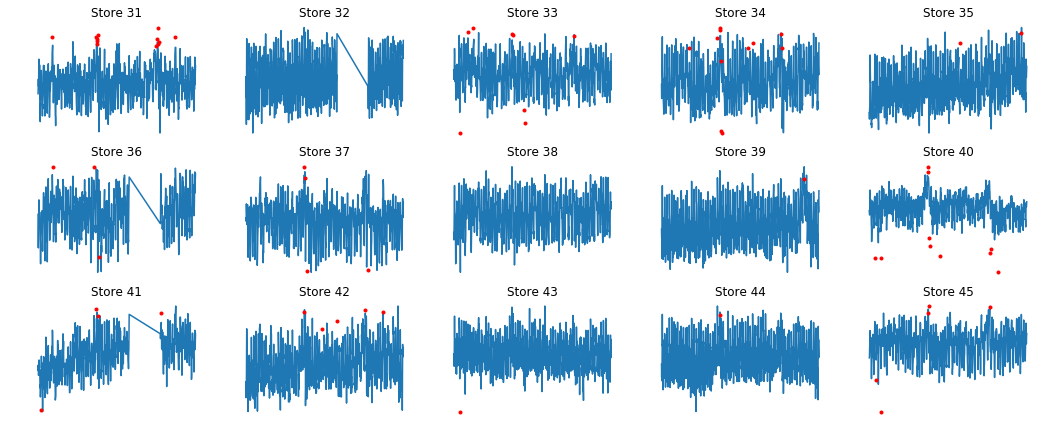

In [47]:
num = 15
st = 31
plt.figure(figsize=(18,38))
for i in range(st,num+st):
    store = i
    
    X1 = df_train.loc[(df_train["Store"] == store) & (df_train["Open"] == 1) & (df_train["Outlier"] == False)]["Date"]
    y1 = df_train.loc[(df_train["Store"] == store) & (df_train["Open"] == 1) & (df_train["Outlier"] == False)]["LogSales"]    
    X2 = df_train.loc[(df_train["Store"] == store) & (df_train["Open"] == 1) & (df_train["Outlier"] == True)]["Date"]
    y2 = df_train.loc[(df_train["Store"] == store) & (df_train["Open"] == 1) & (df_train["Outlier"] == True)]["LogSales"]    
    
    plt.subplot(15,5,i-st+1)
    plt.plot(X1, y1, '-')
    plt.plot(X2, y2, 'r.')
    plt.title("Store {}".format(i))
    plt.axis('off')

### Final models tuning.

For the final prediction, RandomForest and XGBoost ensembles were used. They were fitted to the created features, as well as the outputs of trend models for each store. For hyperparameters search GridSearchCV was used. Since the dataset is a collection of time series, cross-validation uses an appropriate sample splitter, TimeSeriesSplit, which creates training sets that are gradually expanding in time and moves test sets to the future. The results were evaluated using the RMSPE metric specified by the conditions of the competition, which calculates the percentage deviation of the predicted values from the true ones:

$RMSPE = \sqrt{\frac{1}{n}\sum_{i=1}^n(\frac{y_i - \hat{y_i}}{y_i})^2}$,

where y - true value, $\hat{y}$ - predicted value, n - number of observations. The observations with zero sales are ignored.

In [48]:
def rmspe(data, y_pred):
    y_true = data["Sales"]
    y_pred = y_pred[y_true!=0]
    y_true = y_true[y_true!=0]
    return np.sqrt(np.mean(((y_true - y_pred) / y_true)**2))

# RMSPE for GridSearchCV.
def _score_rmspe(estimator, X, y):    
    y_pred = estimator.predict(X)    
    y = np.expm1(y)
    y_pred = np.expm1(y_pred)
    rmspe = np.sqrt(np.mean(((y - y_pred) / y)**2))
    return -rmspe

# RMSPE for XGBoost.
def rmspe_metric_xgb(preds, train_data):
    y_true = train_data.get_label()
    y_pred = preds[y_true!=0]
    y_true = y_true[y_true!=0]
    y_pred = np.expm1(y_pred)
    y_true = np.expm1(y_true)
    return "rmspe", np.sqrt(np.mean(((y_true - y_pred) / y_true)**2))

# Makes a .csv for submission.
def make_submission(y_hat, Name="test_submission.csv"):
    temp = df_test.copy()
    temp["Sales"] = y_hat
    temp.sort_index(inplace=True)
    temp = temp[["Id", "Sales"]]
    temp.to_csv(Name, index=False)

As a baseline model for submit a cross-validated ridge regression was used. The Kaggle submission result was private board RMSPE: 0.18892, public: 0.16580 (public was calculated for the first two weeks of prediction, private for the remaining four).

In [49]:
X_cv = df_train.sort_values("Date").loc[df_train["Open"] == 1][features_log].values
y_cv = df_train.sort_values("Date").loc[df_train["Open"] == 1]["LogSales"].values

splitter = TimeSeriesSplit(n_splits=3).split(X_cv)

reg = RidgeCV(alphas=(0.001, 0.01, 0.1, 1.0, 10.0, 100), cv=splitter, scoring=_score_rmspe)
X_train = df_train.loc[df_train["Open"]==1, features_log].values
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
y_train = df_train.loc[df_train["Open"]==1, "LogSales"].values
reg.fit(X_train, y_train)
print("R^2:", reg.score(X_train, y_train))
print("RMSPE:", rmspe(df_train[df_train["Open"]==1], np.expm1(reg.predict(X_train))))

X_test = scaler.transform(df_test[features_log].values)
y_hat_ridge = np.expm1(reg.predict(X_test))

make_submission(y_hat_ridge)

R^2: 0.8415703062150213
RMSPE: 0.22977941629169654


Hyperparameters search for RandomForest. It was conducted iteratively. The number of trees and sampling parameters (bootstrap и max_features) were selected first, then the parameters of the trees (depth and branching).

In [ ]:
model = RandomForestRegressor(n_jobs=6, verbose=0, random_state=42)

param_grid = {"n_estimators" : [100], #[30, 100, 200],
              "bootstrap": [True], #[True, False],
              "max_features": ["sqrt"], #[None, "sqrt", "log2"],
              "max_depth": [None], #[6, 9, 15, None]
              "min_samples_split": [5], # [2, 5, 10],
              "min_samples_leaf": [2], #[1, 2, 4, 50],
              "max_leaf_nodes": [None], #[None, 2, 10, 50],
              "min_weight_fraction_leaf": [0.0] #[0.0, 0.2, 0.4]
             }

X_cv = df_train.sort_values("Date").loc[df_train["Open"] == 1][features_log].values
y_cv = df_train.sort_values("Date").loc[df_train["Open"] == 1]["LogSales"].values

splitter = TimeSeriesSplit(n_splits=3).split(X_cv)
gs = GridSearchCV(estimator=model, param_grid=param_grid, scoring=_score_rmspe, cv=splitter, verbose=3)
gs.fit(X_cv, y_cv)
gs.grid_scores_

In [67]:
gs.best_params_

{'bootstrap': True,
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'min_samples_leaf': 2,
 'min_samples_split': 5,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100}

In [50]:
def apply_rf(features):
    X_train = df_train.loc[df_train["Open"] == 1][features]
    y_train = df_train.loc[df_train["Open"] == 1][["LogSales"]]
    
    reg_rf = RandomForestRegressor(n_estimators=100, n_jobs=6, max_features="sqrt", max_depth=None, 
                                   min_samples_leaf=2, min_samples_split=5, verbose=1)
    reg_rf.fit(X_train, y_train)    
    return reg_rf

def predict_rf(features):
    X_test = df_test[features]    
    return np.expm1(reg_rf.predict(X_test))

In [ ]:
reg_rf = apply_rf(features_log)
y_hat_rf = predict_rf(features_log)
make_submission(y_hat_rf, "submission_RF.csv")

Submission results: Private RMSPE: 0.12134, Public: 0.11052. Below is feature importance chart. It shows that the most important features for random forest were aggregated values and the calculated trend.


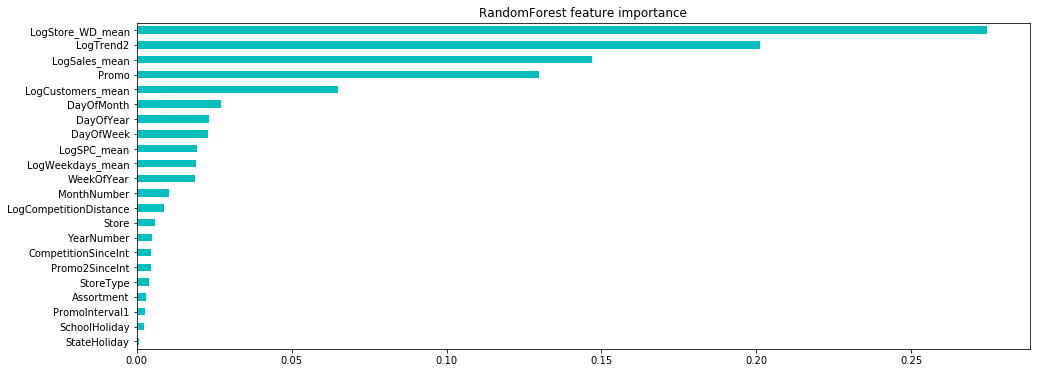

In [52]:
feat_importances = pd.Series(reg_rf.feature_importances_, index=features_log)
plt.figure(figsize=(16, 6))
feat_importances.sort_values().plot(kind="barh", color="c")
plt.title("RandomForest feature importance")
plt.show()

Hyperparameters search for XGBoost. First, the number of trees (boost_rounds) was selected through the cross-validator of the XGBoost library. Their number was chosen 1000, after which the validation error decrease slows down, in contrast to the training error (chart below), which can lead to overfitting.

In [55]:
X_train = df_train.loc[df_train["Open"] == 1][features_log]
y_train = df_train.loc[df_train["Open"] == 1][["LogSales"]]

dtrain = xgb.DMatrix(X_train, y_train)
num_round = 2500
    
param = {"max_depth": 6,
        "eta": 0.1,
        "subsample": 1,
        "colsample_bytree": 1,
        "silent": 1, 
        "objective": "reg:linear",
        "nthread": 6,
        "seed": 42}

cv_xgb = xgb.cv(param, dtrain, num_round, nfold=3, feval=rmspe_metric_xgb, verbose_eval=250, early_stopping_rounds=50)

[0]	train-rmse:7.44333+0.000419079	train-rmspe:0.999534+0	test-rmse:7.44333+0.000867969	test-rmspe:0.999534+4.71405e-07
[250]	train-rmse:0.103086+8.33307e-05	train-rmspe:0.112219+0.00187659	test-rmse:0.104915+0.000420362	test-rmspe:0.114922+0.00348298
[500]	train-rmse:0.0958833+0.000432817	train-rmspe:0.104119+0.00213102	test-rmse:0.098889+0.0001953	test-rmspe:0.108729+0.00322923
[750]	train-rmse:0.091619+0.000250081	train-rmspe:0.0989437+0.00159301	test-rmse:0.0956527+0.00035588	test-rmspe:0.105283+0.00335912
[1000]	train-rmse:0.0885157+0.000240335	train-rmspe:0.094761+0.00185859	test-rmse:0.0935083+0.000325669	test-rmspe:0.10302+0.00329059
[1250]	train-rmse:0.0860623+0.000162891	train-rmspe:0.091508+0.00133447	test-rmse:0.091998+0.000295814	test-rmspe:0.10148+0.00328033
[1500]	train-rmse:0.084069+8.61665e-05	train-rmspe:0.088674+0.000567898	test-rmse:0.090886+0.000297464	test-rmspe:0.100404+0.00330326
[1750]	train-rmse:0.0823927+9.15144e-05	train-rmspe:0.0865213+0.000382994	test-rmse

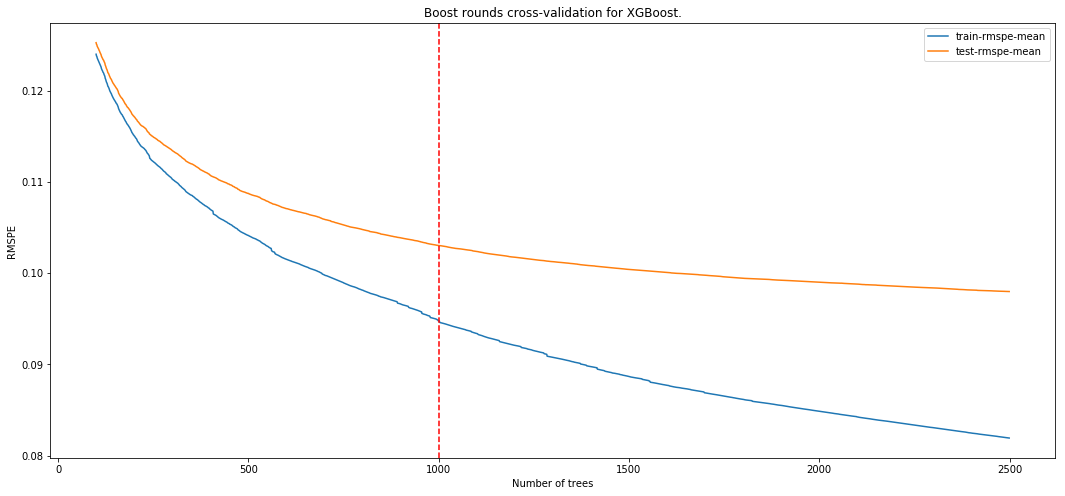

In [56]:
plt.figure(figsize=(18, 8))
cv_xgb["train-rmspe-mean"][100:].plot()
cv_xgb["test-rmspe-mean"][100:].plot()
plt.axvline(1000, color="r", linestyle="--")
plt.title("Boost rounds cross-validation for XGBoost.")
plt.xlabel("Number of trees")
plt.ylabel("RMSPE")
plt.legend()
plt.show()

Further search of hyperparameters. Again, iteratively were chosen and fixed the parameters of the ensemble, trees, regularizers.

In [ ]:
model = xgb.XGBRegressor(n_estimators=1000, n_jobs=6, seed=42)

param_grid = {"max_depth" : [12], #[6, 10, 12],
              "learning_rate": [0.01], #[0.01, 0.1],
              "min_child_weight": [1], #[1, 2], #[0.01, 0.1],
              "gamma": [0], #[0, 0.1],
              "subsample": [0.8], #[0.8, 1],
              "colsample_bytree": [0.7], #[0.7, 1],
              "reg_alpha": [0], #[0, 0.1, 0.2, 0.5],
              "reg_lambda": [10] #[10, 20, 100] #[0.5, 1, 2, 10]
             }

X_cv = df_train.sort_values("Date").loc[df_train["Open"] == 1][features_log].values
y_cv = df_train.sort_values("Date").loc[df_train["Open"] == 1]["LogSales"].values

splitter = TimeSeriesSplit(n_splits=3).split(X_cv)
gs = GridSearchCV(estimator=model, param_grid=param_grid, scoring=_score_rmspe, cv=splitter, verbose=3)
gs.fit(X_cv, y_cv)
gs.grid_scores_

In [380]:
gs.best_params_

{'colsample_bytree': 0.7,
 'gamma': 0,
 'learning_rate': 0.01,
 'max_depth': 12,
 'min_child_weight': 1,
 'reg_alpha': 0,
 'reg_lambda': 10,
 'subsample': 0.8}

In [209]:
def apply_xgb(features, num_round=1000):
    X_train, X_val, y_train, y_val = train_test_split(df_train.loc[df_train["Open"] == 1][features],
                                                        df_train.loc[df_train["Open"] == 1][["LogSales"]],
                                                        test_size=0.1, random_state=42)
    
    dtrain = xgb.DMatrix(X_train, y_train)
    dval = xgb.DMatrix(X_val, y_val)
    num_round = num_round
    evallist = [(dtrain, "train"), (dval, "val")]
    
    param = {"max_depth": 12,
             "eta": 0.01,
             "gamma": 0,
             "alpha": 0,
             "lambda": 10,
             "subsample": 0.8,
             "colsample_bytree": 0.7,
             "min_child_weight": 1,
             "silent": 1, 
             "objective": "reg:linear",
             "nthread": 6,
             "seed": 42}    

    reg_xgb = xgb.train(param, dtrain, num_round, evallist, feval=rmspe_metric_xgb, 
                        verbose_eval=250, early_stopping_rounds=250)
    
    return reg_xgb

def predict_xgb(features):
    X_test = df_test[features]
    dtest = xgb.DMatrix(X_test)
    return np.expm1(reg_xgb.predict(dtest))

In [210]:
reg_xgb = apply_xgb(features_log, 1000)
y_hat_xgb = predict_xgb(features_log)
make_submission(y_hat_xgb, "submission_XGB.csv")

[0]	train-rmse:8.18708	val-rmse:8.18883	train-rmspe:0.999865	val-rmspe:0.999865
Multiple eval metrics have been passed: 'val-rmspe' will be used for early stopping.

Will train until val-rmspe hasn't improved in 250 rounds.
[250]	train-rmse:0.679569	val-rmse:0.680336	train-rmspe:0.486334	val-rmspe:0.486523
[500]	train-rmse:0.11989	val-rmse:0.122176	train-rmspe:0.118748	val-rmspe:0.11924
[750]	train-rmse:0.09396	val-rmse:0.098387	train-rmspe:0.101113	val-rmspe:0.104092
[999]	train-rmse:0.087234	val-rmse:0.093369	train-rmspe:0.094438	val-rmspe:0.099648


Submission result for XGBoost: private RMSPE score: 0.12056, public: 0.10954. The most important features for this model shown in chart. Here, time series trends, day of year and store number moved to top.

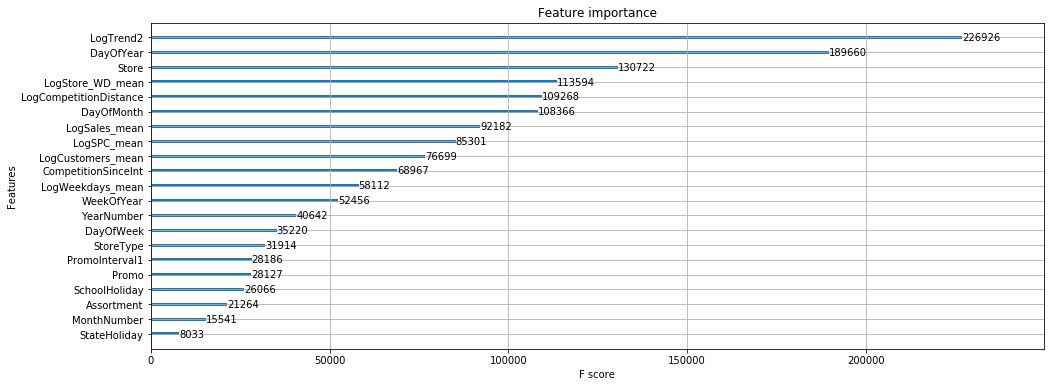

In [170]:
fig, ax = plt.subplots(figsize=(16, 6))
xgb.plot_importance(reg_xgb, ax)
plt.show()

Averaging the outputs of RandomForest and XGBoost.

In [214]:
make_submission(np.mean([y_hat_rf, y_hat_xgb], axis=0), "submission_RF-XGB.csv")

Final achieved submission score was private board RMSPE: 0.11957, public: 0.10862. That result is in top 15% for private board. The median private RMSPE for that competition is 0.12967.

Possibly, a more detailed analysis of the time series of each store and the construction of specialized models for them would lead to an improvement in the result. Or clustering stores according to the "similarity" of their sales dynamics by transposing a pivot table of time series (every day as a feature), lowering the dimension, and searching for similar stores. Another possible improvement is the search for additional data, such as the actual location of stores, type of settlement, average income of the population in this area, weather changes, environmental and epidemiological conditions (stores are pharmacies), etc.